In [1]:
from os import getcwd
from os.path import join, abspath

import numpy as np
import pickle
import torch
import torch.nn.functional as F
import torch.optim as optim

from src.data.load_dataset import load_kmnist
from src.models.networks import V1_mnist_RFNet, classical_RFNet
from src.models.utils import train, test

In [2]:
data_dir = abspath(join(getcwd(), '../../'))
device = torch.device('cuda' if torch.cuda.is_available else 'cpu') 

In [3]:
# load data
train_batch_size, train_percentage = 256, 0.999
train_loader, val_loader, test_loader = load_kmnist(train_batch_size, train_percentage)
batch_len = len(train_loader)

# training params
scale = 2/784 # since we do a cholesky before generating weights
num_epochs = 20
num_trials = 5
log_interval = 100
loss_fn = F.cross_entropy

# V1 params
compatible = {'s': 5, 'f':2}
incompatible = {'s': 0.5, 'f':0.5}

# params to iterate over
hidden_size_list = [1000]
lr_list = [1E-4, 1E-3]

## V1 Net

In [ ]:
s, f = compatible['s'], compatible['f']
v1_train_loss = {h: {lr: {'mean': [], 'std': []} for lr in lr_list} for h in hidden_size_list}
v1_test_accuracy = {h: {lr: {'mean': [], 'std': []} for lr in lr_list} for h in hidden_size_list}

for h in hidden_size_list:
    for lr in lr_list:
        print(h, lr)
        train_loss = np.zeros((num_trials, len(train_loader) * num_epochs))
        test_accuracy = np.zeros((num_trials, num_epochs))
        for trial in range(num_trials):
            
            # define the model and optimizer
            model = V1_mnist_RFNet(h, s, f, center=None, scale=scale).to(device)
            model.v1_layer.weight.requires_grad = True
            optimizer = optim.Adam(model.parameters(), lr=lr)
            
            for epoch in range(num_epochs):
                loss = train(log_interval, device, model, train_loader, optimizer, epoch, loss_fn, verbose=False)
                accuracy = test(model, device, test_loader, verbose=False)
                train_loss[trial, epoch * batch_len:(epoch+1) * batch_len] = loss
                test_accuracy[trial, epoch] = accuracy
            
        # train error
        v1_train_loss[h][lr]['mean'] = np.mean(train_loss, axis=0)
        v1_train_loss[h][lr]['std'] = np.std(train_loss, axis=0) / np.sqrt(num_trials)
        
        # test error
        v1_test_accuracy[h][lr]['mean'] = np.mean(test_accuracy, axis=0)
        v1_test_accuracy[h][lr]['std'] = np.std(test_accuracy, axis=0) / np.sqrt(num_trials)

1000 0.0001


## Classical Net

In [ ]:
inp_size = (1, 28, 28)
classical_train_loss = {h: {lr: {'mean': [], 'std': []} for lr in lr_list} for h in hidden_size_list}
classical_test_accuracy = {h: {lr: {'mean': [], 'std': []} for lr in lr_list} for h in hidden_size_list}

for h in hidden_size_list:
    for lr in lr_list:
        print(h, lr)
        train_loss = np.zeros((num_trials, len(train_loader) * num_epochs))
        test_accuracy = np.zeros((num_trials, num_epochs))
        for trial in range(num_trials):
            
            # define the model and optimizer
            model = classical_RFNet(inp_size, h, scale=scale).to(device)
            model.RF_layer.weight.requires_grad = True
            optimizer = optim.Adam(model.parameters(), lr=lr)
            
            for epoch in range(num_epochs):
                loss = train(log_interval, device, model, train_loader, optimizer, epoch, loss_fn, verbose=False)
                accuracy = test(model, device, test_loader, verbose=False)
                train_loss[trial, epoch * batch_len:(epoch+1) * batch_len] = loss
                test_accuracy[trial, epoch] = accuracy
            
        # train error
        classical_train_loss[h][lr]['mean'] = np.mean(train_loss, axis=0)
        classical_train_loss[h][lr]['std'] = np.std(train_loss, axis=0) / np.sqrt(num_trials)
        
        # test error
        classical_test_accuracy[h][lr]['mean'] = np.mean(test_accuracy, axis=0)
        classical_test_accuracy[h][lr]['std'] = np.std(test_accuracy, axis=0) / np.sqrt(num_trials)

## incompatible net

In [ ]:
s, f = incompatible['s'], incompatible['f']
incompatible_train_loss = {h: {lr: {'mean': [], 'std': []} for lr in lr_list} for h in hidden_size_list}
incompatible_test_accuracy = {h: {lr: {'mean': [], 'std': []} for lr in lr_list} for h in hidden_size_list}

for h in hidden_size_list:
    for lr in lr_list:
        print(h, lr)
        train_loss = np.zeros((num_trials, len(train_loader) * num_epochs))
        test_accuracy = np.zeros((num_trials, num_epochs))
        for trial in range(num_trials):
            
            # define the model and optimizer
            model = V1_mnist_RFNet(h, s, f, center=None, scale=scale).to(device)
            model.v1_layer.weight.requires_grad = True
            optimizer = optim.Adam(model.parameters(), lr=lr)
            
            for epoch in range(num_epochs):
                loss = train(log_interval, device, model, train_loader, optimizer, epoch, loss_fn, verbose=False)
                accuracy = test(model, device, test_loader, verbose=False)
                train_loss[trial, epoch * batch_len:(epoch+1) * batch_len] = loss
                test_accuracy[trial, epoch] = accuracy
            
        # train error
        incompatible_train_loss[h][lr]['mean'] = np.mean(train_loss, axis=0)
        incompatible_train_loss[h][lr]['std'] = np.std(train_loss, axis=0) / np.sqrt(num_trials)
        
        # test error
        incompatible_test_accuracy[h][lr]['mean'] = np.mean(test_accuracy, axis=0)
        incompatible_test_accuracy[h][lr]['std'] = np.std(test_accuracy, axis=0) / np.sqrt(num_trials)

In [ ]:
# save results
s, f = compatible['s'], compatible['f']
results = {}
results['V1'] = {'train_loss': v1_train_loss, 'test_accuracy': v1_test_accuracy}
results['classical'] = {'train_loss': classical_train_loss, 'test_accuracy': classical_test_accuracy}
results['incompatible'] = {'train_loss': incompatible_train_loss, 'test_accuracy': incompatible_test_accuracy}

with open(data_dir + '/models/results/initialize_kmnist/full_data/clf_s=%0.2f_f=%0.2f_ADAM_torch.pickle' % (s, f), 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

(0.0, 25.0)

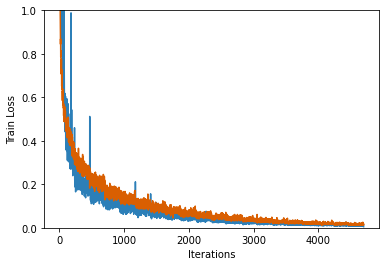

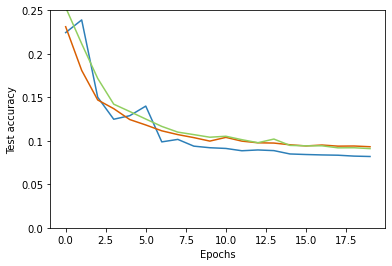

In [40]:
import matplotlib.pyplot as plt
s, f = 5, 2
with open(data_dir + '/models/results/initialize_kmnist/full_data/clf_s=%0.2f_f=%0.2f_SGD_torch.pickle' % (s, f), 'rb') as handle:
    results = pickle.load(handle)

h, lr = 1000, 1E-1
fig = plt.figure()
plt.plot(results['V1']['train_loss'][h][lr]['mean'], c='#2c7fb8')
plt.plot(results['classical']['train_loss'][h][lr]['mean'], c='#d95f02')
# plt.plot(results['incompatible']['train_loss'][h][lr]['mean'][::235], c='#91cf60')
plt.ylim(0, 1)
plt.xlabel('Iterations')
plt.ylabel('Train Loss')

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(100 - results['V1']['test_accuracy'][h][lr]['mean'], c='#2c7fb8')
plt.plot(100 - results['classical']['test_accuracy'][h][lr]['mean'], c='#d95f02')
plt.plot(100 - results['incompatible']['test_accuracy'][h][lr]['mean'], c='#91cf60')
plt.xlabel('Epochs')
plt.ylabel('Test accuracy')
plt.yticks(np.arange(0, 100, 5))
ax.set_yticklabels(np.arange(0, 100, 5) * 0.01)
plt.ylim([0, 25])

In [ ]:
results['V1']['test_accuracy'][h][lr]['mean'][::235]

In [8]:
len(train_loader)

235